
# Basic example of usage VisionTransforms



In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, "..")

In [3]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

Let's suppose that datapoint is `((img, scalars), (mask, bboxes, labels))`

In [4]:
img = np.random.randint(0, 70, size=(310, 310, 3), dtype=np.uint8)
img[10:150, 34:120, :] = (127, 22, 234)
img[220:250, 134:180, :] = (22, 234, 123)

mask = np.zeros((310, 310, 3), dtype=np.uint8)
mask[10:150, 34:120, :] = (220, 120, 0)
mask[220:250, 134:180, :] = (23, 33, 220)

bboxes = np.array([
    [34, 10, 120, 150],
    [134, 220, 180, 250],
])
labels = [1, 2]

In [5]:
# !pip install --upgrade git+https://github.com/vfdev-5/ImageDatasetViz
    
from image_dataset_viz import render_datapoint, bbox_to_points

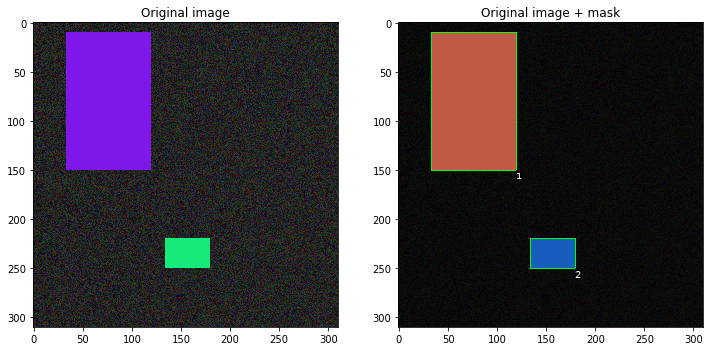

In [6]:
from PIL import Image

rimg = render_datapoint(Image.fromarray(img), Image.fromarray(mask))
rimg = render_datapoint(rimg, [(bbox_to_points(b), str(l)) for b, l in zip(bboxes, labels)])

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Original image")
plt.imshow(img)
plt.subplot(122)
plt.title("Original image + mask")
plt.imshow(rimg)

In [7]:
import vision_transforms as vt

In [8]:
import PIL


class DataTransform(vt.BaseTransform):
    
    def __init__(self):
        
        translate_scale_params = {
            'translate': (0.2, 0.2),
            'scale': (0.7, 1.3)
        }
        self.random_affine = vt.RandomAffine(degrees=0, **translate_scale_params, resample=PIL.Image.BICUBIC)
        self.mask_random_affine = vt.RandomAffine(degrees=0, **translate_scale_params, resample=PIL.Image.NEAREST)        
        self.bbox_random_affine = vt.BBoxRandomAffine(input_canvas_size=310, **translate_scale_params)
        
        self.random_crop = vt.RandomCrop(size=224)
        self.bbox_random_crop = vt.BBoxRandomCrop(input_canvas_size=310, size=224)
        
        self.img_geom = vt.Sequential(
            self.random_affine,
            self.random_crop,
        )
        self.mask_geom = vt.Sequential(
            self.mask_random_affine,
            self.random_crop,
        )        
        self.bbox_geom = vt.Sequential(
            self.bbox_random_affine,
            self.bbox_random_crop,
        )        
        self.img_color = vt.ColorJitter(hue=0.5, saturation=1.0)
        
    def __call__(self, datapoint, rng=None):
        
        x, y = datapoint
        img_rgb, scalars = x
        mask, bboxes, labels = y

        t_img_rgb = self.img_geom(img_rgb, rng)
        t_img_rgb = self.img_color(t_img_rgb)

        t_mask = self.mask_geom(mask, rng)        
        t_bboxes = self.bbox_geom(bboxes, rng)    
        
        return (t_img_rgb, scalars), (t_mask, t_bboxes, labels)
        

dtf = DataTransform()

In [9]:
# dtf

In [91]:
import random

random.seed(12)
vt.set_image_backend("opencv")

rng = random.getstate()

In [92]:
dp = ((img, 123), (mask, bboxes, labels))

t_dp = dtf(dp, rng)

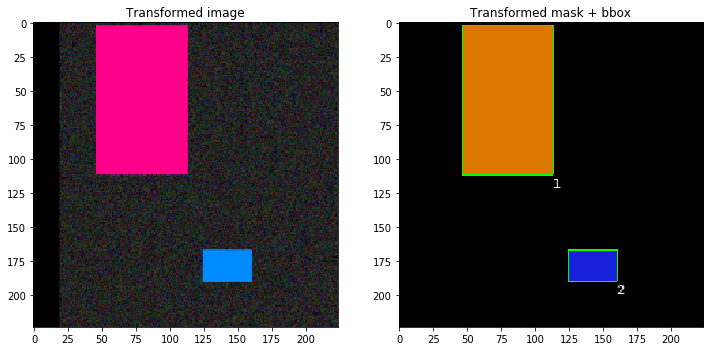

In [93]:
x, y = t_dp
t_img, scalars = x
t_mask, t_bboxes, labels = y


rimg = render_datapoint(Image.fromarray(t_mask), Image.fromarray(t_mask), blend_alpha=0.5)
rimg = render_datapoint(rimg, [(bbox_to_points(b), str(l)) for b, l in zip(t_bboxes, labels)])


plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Transformed image")
plt.imshow(t_img)
plt.subplot(122)
plt.title("Transformed mask + bbox")
plt.imshow(rimg)

In [95]:
import random

random.seed(12)
vt.set_image_backend("pillow")

rng = random.getstate()

In [96]:
dp = ((Image.fromarray(img), 123), (Image.fromarray(mask), bboxes, labels))

t_dp = dtf(dp, rng)

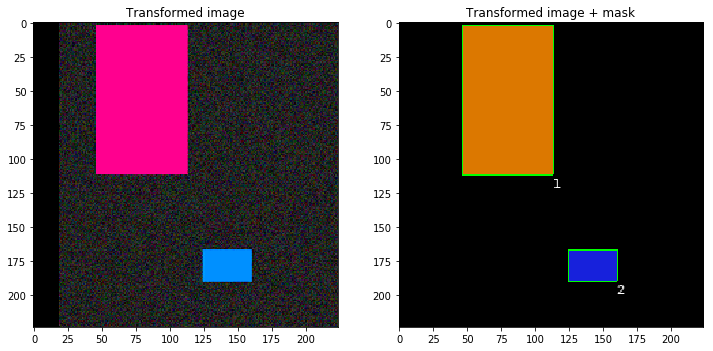

In [97]:
x, y = t_dp
t_img, scalars = x
t_mask, t_bboxes, labels = y


rimg = render_datapoint(t_mask, t_mask, blend_alpha=0.5)
rimg = render_datapoint(rimg, [(bbox_to_points(b), str(l)) for b, l in zip(t_bboxes, labels)])


plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Transformed image")
plt.imshow(t_img)
plt.subplot(122)
plt.title("Transformed image + mask")
plt.imshow(rimg)

In [99]:
from vision_transforms.functional import opencv as Fcv
from vision_transforms.functional import pillow as FPillow

In [100]:
pil_img = Image.fromarray(img)

In [101]:
for a in np.arange(0.0, 1.05, 0.05):
    pil_res = np.asarray(FPillow.adjust_brightness(pil_img, a))
    cv_res = Fcv.adjust_brightness(img, a)
    assert np.allclose(pil_res, cv_res, atol=1), a

In [102]:
for a in np.arange(0.0, 1.05, 0.05):
    pil_res = np.asarray(FPillow.adjust_contrast(pil_img, a))
    cv_res = Fcv.adjust_contrast(img, a)
    assert np.allclose(pil_res, cv_res, atol=2), a

In [103]:
for a in np.arange(0.0, 1.05, 0.05):
    pil_res = np.asarray(FPillow.adjust_saturation(pil_img, a))
    cv_res = Fcv.adjust_saturation(img, a)
    assert np.allclose(pil_res, cv_res, atol=2), a

In [262]:
for a in np.arange(-0.5, 0.5, 0.01):
    pil_res = np.asarray(FPillow.adjust_hue(pil_img, a))
    cv_res = Fcv.adjust_hue(img, a)
    assert np.allclose(pil_res, cv_res, atol=10), a